# To try:
* anomalies: expressed in terms of percentage deviation for each measure? 
* measures: does measure j for asset k inform use about how measure j works for asset m?
* simplest model: assume all measures are normally distributed and independent; compute probability of 

https://challengedata.ens.fr/challenges/39


* 2324 measures per each of 104 week
* sample_id is identical to measure_week
* 34528 measures per weekday 
* 2912 measures for each of 83 asset_id
* 60424 measures for each of 4 measure_type
* 78624 measures for group_id==2 and 163072 measures for group_id==3 
* asset 1 to 27 in group_id==2 and 28 to 83 in group_id==3

# Basic Model
Asset either at capacity or at zero. The state depend on measures (if they are above a cutoff). If we knew the weakly production for each asset, we could estimate a classification model (random forest).

The model here is more complicated because we just observe the production of each group of asset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = pd.options.display.min_rows  = 5000

In [2]:
train_x = pd.read_csv('train_X_9jXqqNo.csv')
train_y = pd.read_csv('train_y.csv')
test_x = pd.read_csv('test_X_Xq5vIGS.csv')
capacity = pd.read_csv('assets.csv')

# a bit of cleaning
for df in [train_x, train_y, test_x, capacity]:
    df.columns = df.columns.str.lower()
train_x.drop(columns='unnamed: 0', inplace=True)
test_x.drop(columns='unnamed: 0', inplace=True)

# capacity
capacity = capacity.rename(columns={'asset_nominal_capacity': 'capacity'})

# for df in [train_x, test_x]:
train_x = train_x.merge(capacity, on='asset_id', how='left')
train_x = train_x.rename(columns={'measure_type': 'type', 
                                  'measure_value': 'value',
                                  'measure_weekday': 'weekday',
                                  'measure_week': 'week'})
train_x = train_x.set_index('asset_id')
train_x.drop(columns='week', inplace=True) # week equals sample_id

# construct percentage capacity
group_capacity = train_x[['group_id', 'capacity']].drop_duplicates()
group_capacity['perc_group_capacity'] = group_capacity.groupby('group_id').transform(lambda x: x / sum(x))
train_x = train_x.merge(group_capacity['perc_group_capacity'], on='asset_id', how='left')

# add group production
train_x = train_x.reset_index().merge(train_y, on='sample_id', how='left')
train_x['group_production'] = train_x['production_group_2']
train_x.loc[train_x.group_id==3, 'group_production'] = train_x.production_group_3
train_x.drop(columns=['production_group_2', 'production_group_3'], inplace=True)

# use weekly averages
train_x = train_x.groupby(['sample_id', 'asset_id', 'type']).agg('mean').reset_index()

In [3]:
top_assets = train_x.drop_duplicates(subset=['asset_id', 'perc_group_capacity']) \
    .sort_values('perc_group_capacity', ascending=False).head(10)
l_top_assets = top_assets.asset_id.unique()
top_assets

,sample_id,asset_id,type,group_id,value,weekday,capacity,perc_group_capacity,group_production
32,1,9,1,2,0.000000,4,413500.0,0.101597,3850220.00
92,1,24,1,2,0.571429,4,314000.0,0.077150,3850220.00
16,1,5,1,2,NaN,4,310000.0,0.076167,3850220.00
48,1,13,1,2,NaN,4,277000.0,0.068059,3850220.00
248,1,63,1,3,0.857143,4,603000.0,0.065584,9019860.32
312,1,79,1,3,2.857143,4,571000.0,0.062103,9019860.32
196,1,50,1,3,6.142857,4,560500.0,0.060961,9019860.32
284,1,72,1,3,0.714286,4,556000.0,0.060472,9019860.32
40,1,11,1,2,NaN,4,245000.0,0.060197,3850220.00
8,1,3,1,2,1.285714,4,238600.0,0.058624,3850220.00


asset 9, capacity 413500.0 /out of mean production 3792966.0


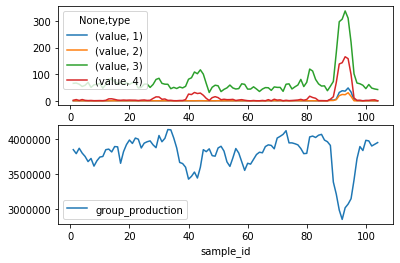

asset 24, capacity 314000.0 /out of mean production 3792966.0


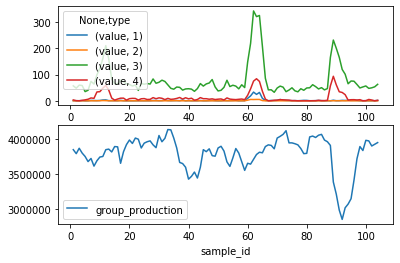

asset 5, capacity 310000.0 /out of mean production 3792966.0


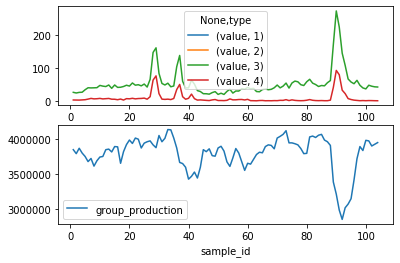

asset 13, capacity 277000.0 /out of mean production 3792966.0


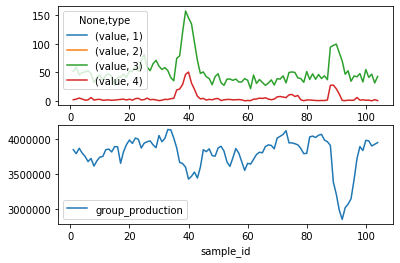

asset 63, capacity 603000.0 /out of mean production 9143706.0


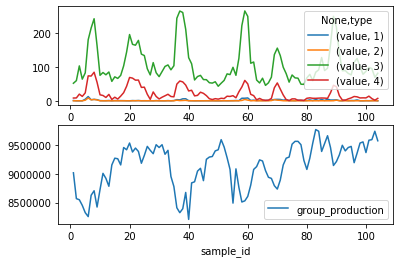

asset 79, capacity 571000.0 /out of mean production 9143706.0


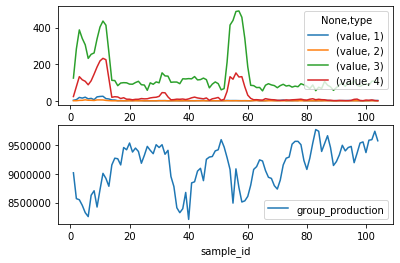

asset 50, capacity 560500.0 /out of mean production 9143706.0


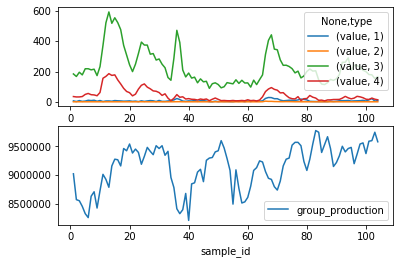

asset 72, capacity 556000.0 /out of mean production 9143706.0


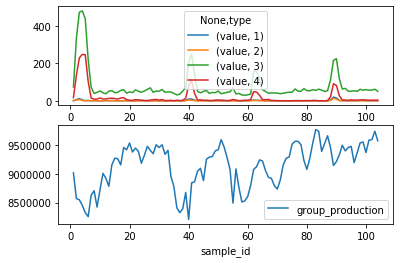

asset 11, capacity 245000.0 /out of mean production 3792966.0


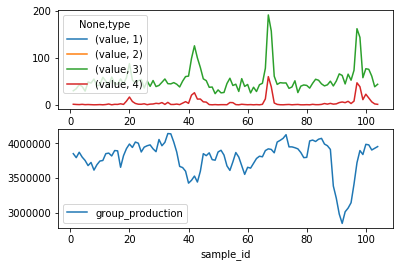

asset 3, capacity 238600.0 /out of mean production 3792966.0


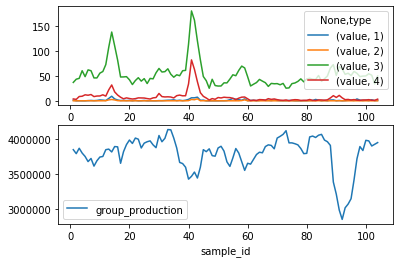

In [6]:
for asset_id in l_top_assets:
    df = train_x.loc[train_x.asset_id == asset_id, :]
    cap = df.capacity.unique()[0]
    prod = np.round(df.group_production.mean())
    print(f'asset {asset_id}, capacity {cap} /out of mean production {prod}')
    fig, axes = plt.subplots(2, 1)
    df.groupby(['sample_id', 'type']).agg({'value': 'mean'}).unstack(1).plot(ax=axes[0])
    df[['sample_id', 'group_production']].set_index('sample_id').plot(ax=axes[1])
    plt.show()

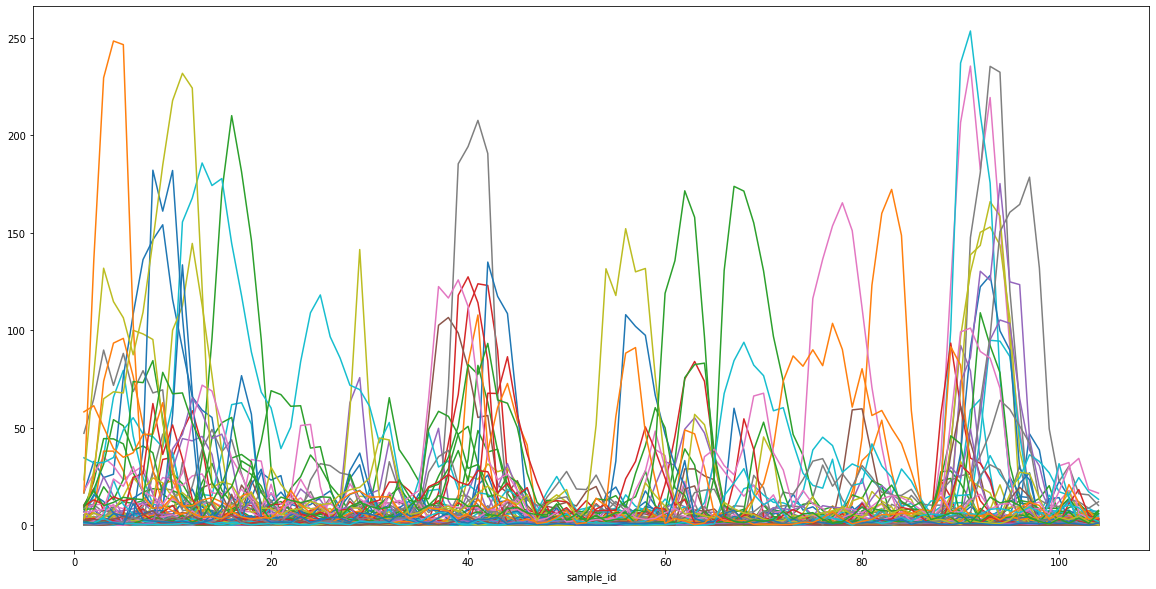

In [29]:
train_x.loc[train_x.type == 4, ['asset_id', 'sample_id', 'value']] \
.set_index(['sample_id', 'asset_id']).unstack(1).plot(figsize=(20, 10), legend=False)
plt.show()

the part below is to be sorted (mostly junk)

In [ ]:
capacity.head(10)

In [ ]:
capacity = pd.read_csv('assets.csv')
capacity.columns = capacity.columns.str.lower()
display(capacity.loc[[0, 42, 69, 77, 78, 81], :])

# capacity
capacity = capacity.rename(columns={'asset_nominal_capacity': 'capacity'})
capacity.set_index('asset_id', inplace=True)
capacity = capacity.merge(train_x['group_id'], left_index=True, right_index=True, how='left').drop_duplicates()
capacity.info()

In [ ]:
train_y.set_index('sample_id').plot()

In [ ]:
train_x.loc[train_x.perc_group_capacity.isna(), ].index.unique()

In [ ]:
train_x.groupby(['group_id', 'asset_id']).perc_group_capacity.mean().sort_values(ascending=False)

In [ ]:
capacity.set_index('asset_id').sort_values('capacity').plot.bar()

In [ ]:
train_y = train_y.set_index('sample_id')
train_y.plot()

In [ ]:
mask = (train_x.asset_id==27)
print(train_x.loc[mask, 'asset_nominal_capacity'].unique()[0])
train_x_sample = train_x.loc[mask, ].set_index(['measure_week', 'measure_weekday', 'measure_type'])
train_x_sample['measure_value'].unstack(level=2).groupby('measure_week').agg('mean').plot()
plt.show()

In [ ]:
train_x.groupby(['measure_week', 'asset_id']).agg({'measure_value': ['sum', 'std'], 'asset_nominal_capacity': ['mean']})